<h1> NLP - Extracted Entities </h1>

In this program, we are performing entity extraction and a thematic analysis on a set of 138 research papers and articles related to heat stress (which were downloaded from JSTOR or using Google Scholar, from various open-source journals). The papers were manually downloaded to ensure relevance. Only 138 papers were selected to avoid overloading the kernel, since analyzing a larger dataset of papers would have slowed down processing. If needed, more papers can eventually be analyzed using this program.

The goal of this exercise was to get a starting point from the literature to obtain mitigation measures most relevant to heat conditions like heat stress, to give input to the notifications (i.e., mitigation measures) section of our website.


<h4> Notes: </h4>
    1. In total, this program may take up to 40 minutes to run in its entirety. <br>
    2. You need to have a version of NumPy < 2.0.0 and an older version of spaCy for the program to run. Below, please check what versions of these packages you have - and downgrade them, if necessary.<br>
    3. Make sure the "papers" folder is in the same directory as this program, if you want to run all the cells by yourself.



In [72]:
#!pip install numpy<2.0 spacy<3.8 pandas scikit-learn nltk pymupdf matplotlib seaborn networkx rapidfuzz

# Check your spaCy and NumPy versions before proceeding!
print("spaCy version:", spacy.__version__)
print("NumPy version:", np.__version__)

spaCy version: 3.7.4
NumPy version: 1.26.4


In [64]:
#import packages
import os
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
import fitz
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
import random
from collections import defaultdict, Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from rapidfuzz import process, fuzz
import csv

# Download (if necessary) and load spaCy model for NER
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2_000_000  # So that the program does not run out of space
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

In [31]:
# Define a dictionary of common abbreviations
abbreviation_map = {
    "WBGT": "Wet Bulb Globe Temperature",
    "AC": "Air Conditioning",
    "UHI": "Urban Heat Island",
    "COP": "Coefficient of Performance",
    "RH": "Relative Humidity",
    "UTCI": "Universal Thermal Climate Index",
    "PPE": "Personal Protective Equipment",
    "OHS": "Occupational Health and Safety",
    "HVAC": "Heating, Ventilation, and Air Conditioning",
    "EMS": "Emergency Medical Services"
}

# Common heat stress keywords
heat_stress_keywords = ["heat stress", "thermal comfort", "acclimatization", "cooling zones", 
        "cooling shelters", "hydration stations", "fans", "air conditioning", 
        "shade", "rest breaks", "water supply", "ventilation", "protective clothing",
        "green roofs", "urban cooling", "heatwaves", "extreme temperatures", 
        "humidity", "heat index", "wbgt"]

# Further relevant terms
relevant_terms = {
"greenery", "albedo", "urban heat stress", "green infrastructure", "heat island effect", 
"heat stress", "temperature", "humidity", "urban_cooling", "green roofs", "cool roofs", 
"shading", "evapotranspiration", "thermal insulation", "surface temperature", "precipitation", 
"heat index", "dehydration", "heat exhaustion", "heat stroke", "first aid cooling", "protective clothing", 
"ppe", "shelter", "water station", "air conditioning", "cooling shelters", "hydration stations", 
"fans", "ventilation", "acclimatization", "rest breaks", "thermal comfort", "wbgt", "cooling zones", 
"water supply", "extreme temperatures", "solar radiation", "wind speed", "urban greenery", "vegetation", 
"shade provision", "outdoor thermal comfort", "heat adaptation", "climate resilience", "climate change", 
"urban adaptation", "sustainable cities", "resilient urban planning", "urban heat mitigation", "thermal stress", 
"water conservation", "green walls", "climate action", "environmental heat", "urban ecosystem", "urban cooling systems", 
"weather extremes", "microclimates", "heat wave", "climate models", "adaptive capacity", "community resilience", 
"sustainable urban development", "outdoor heat", "overheating", "natural cooling", "heat exposure", "temperature control", 
"indoor temperature", "built environment", "environmental hazards", "flooding", "climate vulnerability", "heat-related mortality", 
"heat-related illnesses", "urban forestry", "cooling interventions", "urban heat management", "ecological cooling", 
"ecosystem-based adaptation", "climate-sensitive planning", "adaptive urban design", "rainwater harvesting", 
"smart cities", "green space", "social vulnerability", "green space access", "cooling technologies", "climate emergency", 
"public health", "heat-related deaths", "disaster preparedness", "urban health", "environmental health", "energy efficiency", 
"sustainable energy", "climate action plans", "health effects of heat", "green building", "urban resilience", 
"low-carbon cities", "energy demand", "cool pavements", "permeable surfaces", "sustainable cooling", "climate justice", 
"urban forestry programs", "carbon footprint", "zero-emission cities", "heat reduction strategies",

# Worker safety terms
"worker safety", "occupational health", "heat stress prevention", "heat acclimatization", "heat exposure limits", 
"workplace safety", "safety protocols", "ppe compliance", "personal protective equipment", "hydration", "safety measures", 
"rest breaks", "shift schedules", "workplace cooling", "workplace hydration", "heat exhaustion prevention", 
"fatigue prevention", "high-risk workers", "outdoor labor", "construction workers", "farm workers", "public works", 
"industrial safety", "workplace health", "safety training", "heat-related injury prevention", "first aid", "medical response",

# Single words
"acclimation", "safety", "stress", "temperature", "hydration", "rest", "shade", "climate", "air", "heat", 
"cooling", "humidity", "well-being", "workforce", "temperature", "health", "risk", "protection", "monitoring", 
"exposure", "evaporation", "convection", "conduction", "ambient", "radiation", "urban", "zone", "protocol", 
"emergency", "safety", "intervention", "prevention", "exhaustion", "heatstroke", "recovery", "cooling", 
"physiological", "behavioral", "healthcare", "worksite", "monitor", "temperature", "workplace"
}

# PDF folder where research papers have been stored
pdf_folder='papers/'

<h4>First, we will try a simple NER procedure, using the dicts defined above.</h4>

In [36]:
# Step 1: Load and preprocess
def load_and_clean_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    text = ""
    for page in doc:
        text += page.get_text()
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Step 2: Tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

# Step 3: Named Entity Recognition (NER) for heat stress terms
def extract_heat_stress_entities(text):
    print(len(text))
    
    # Replace known abbreviations before extraction
    for abbr, full_form in abbreviation_map.items():
        text = text.replace(abbr.lower(), full_form.lower())

    doc = nlp(text)
    heat_stress_entities = []

    # Accept entity labels that may relate to heat stress topics
    allowed_labels = {
        'ORG', 'GPE', 'FAC', 'PRODUCT', 'LOC', 'EVENT', 'NORP',
        'LAW', 'LANGUAGE', 'MISC'  
    }

    for ent in doc.ents:
        if ent.label_ in allowed_labels:
            heat_stress_entities.append(ent.text)

    return heat_stress_entities


# Step 4: Process extracted entities (replace abbreviations, filter terms)
def process_entities(extracted_entities, relevant_terms):
    # Normalize and deduplicate entities
    normalized_entities = set()

    for entity in extracted_entities:
        # Replace abbreviations again
        normalized = abbreviation_map.get(entity, entity).lower().strip()

        # Remove unwanted short terms or symbols
        if normalized in {"•", "ref", "fig", "≥", "≥"}:
            continue

        # Match with relevant terms (case-insensitive)
        if normalized in relevant_terms:
            normalized_entities.add(normalized)

        # Fuzzy matching (uncomment below to use fuzzywuzzy/rapidfuzz)
        match, score, _ = process.extractOne(normalized, relevant_terms, scorer=fuzz.partial_ratio)
        if score > 85:
            normalized_entities.add(match)

    print(f'length of extracted_entities after processing: {len(normalized_entities)}')
    return list(normalized_entities)

In [33]:
# Process the popers - run above functions
def process_pdfs(random_sample):
    all_pdfs = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    
    if random_sample == 1:
        sample_size = min(50, len(all_pdfs))
        sampled_pdfs = random.sample(all_pdfs, sample_size)
    else:
        sampled_pdfs = all_pdfs
        sample_size = len(sampled_pdfs)

    all_cleaned_texts = []
    all_entities = []
    for count, pdf_file in enumerate(sampled_pdfs, start=1):
        file_path = os.path.join(pdf_folder, pdf_file)
        print(f"{count}. Processing {pdf_file} ...")

        # load and clean pdf text
        text = load_and_clean_text_from_pdf(file_path)
        cleaned_text = tokenize_and_remove_stopwords(text)
        all_cleaned_texts.append(cleaned_text)

        # extract entities
        entities = extract_heat_stress_entities(cleaned_text)
        processed_entities = process_entities(entities, relevant_terms)
        all_entities.extend(processed_entities)

    print(f"Total extracted entities from {sample_size} papers: {len(all_entities)}")
    return all_entities, all_cleaned_texts

In [37]:
# TESTRUN: Run the above code on the 50 random PDFs from the papers folder - this cell took around 46 sec to run
entities_50_papers, cleaned_50_texts = process_pdfs(1)

1. Processing 84.pdf ...
65106
length of extracted_entities after processing: 9
2. Processing HeatRelatedDeathsAmong-2008.pdf ...
21420
length of extracted_entities after processing: 7
3. Processing moran-et-al-2023-beating-the-heat-military-training-and-operations-in-the-era-of-global-warming.pdf ...
35559
length of extracted_entities after processing: 4
4. Processing 1-s2.0-S0306456513000521-main.pdf ...
24560
length of extracted_entities after processing: 3
5. Processing Effects_of_Heat_Stress_Exposure_and_Clim.pdf ...
32059
length of extracted_entities after processing: 8
6. Processing MDL-109-163.pdf ...
142968
length of extracted_entities after processing: 15
7. Processing Ma-EvaluatingEffectivenessMitigation-2018.pdf ...
33097
length of extracted_entities after processing: 10
8. Processing annurev-publhealth-060222-034715.pdf ...
57424
length of extracted_entities after processing: 12
9. Processing 1471-2458-13-1004.pdf ...
44153
length of extracted_entities after processing: 11

In [39]:
# Now, all papers will be processed - this cell took about 161 secs to run
entities_all_papers, all_texts = process_pdfs(0)

1. Processing 0.pdf ...
72534
length of extracted_entities after processing: 11
2. Processing 1-s2.0-S0001457513003230-main.pdf ...
65883
length of extracted_entities after processing: 12
3. Processing 1-s2.0-S0003687024000589-main.pdf ...
43246
length of extracted_entities after processing: 6
4. Processing 1-s2.0-S0013935118305772-main.pdf ...
42507
length of extracted_entities after processing: 10
5. Processing 1-s2.0-S001393512100075X-main.pdf ...
68018
length of extracted_entities after processing: 13
6. Processing 1-s2.0-S0013935125007467-main.pdf ...
41047
length of extracted_entities after processing: 9
7. Processing 1-s2.0-S0048969718323313-main.pdf ...
55958
length of extracted_entities after processing: 9
8. Processing 1-s2.0-S0048969721033313-main.pdf ...
46409
length of extracted_entities after processing: 9
9. Processing 1-s2.0-S0169204614000498-main.pdf ...
31905
length of extracted_entities after processing: 5
10. Processing 1-s2.0-S0306456513000521-main.pdf ...
24560
le

In [49]:
# Print summary of extraction
print(f'Number of unique entities: {len(set(entities_all_papers))}')

# Count frequencies
entity_counts = Counter(entities_all_papers)

# Get only duplicates and sort them by count (descending)
duplicates_sorted = sorted(
    [(entity, count) for entity, count in entity_counts.items() if count > 1],
    key=lambda x: x[1],
    reverse=True
)

# Print
for entity, count in duplicates_sorted:
    print(f"{entity}: {count}")

Number of unique entities: 88
air conditioning: 129
air: 127
health: 80
heat: 80
risk: 59
safety: 50
public health: 49
environmental heat: 45
rest: 34
climate: 33
fans: 31
occupational health: 31
urban: 24
disaster preparedness: 22
humidity: 22
climate change: 19
environmental health: 19
temperature: 18
protection: 15
ambient: 14
healthcare: 13
climate action: 13
medical response: 13
personal protective equipment: 12
greenery: 12
radiation: 11
natural cooling: 10
prevention: 9
built environment: 8
zone: 8
emergency: 8
climate action plans: 8
acclimatization: 7
physiological: 6
intervention: 6
hydration: 5
convection: 5
sustainable cities: 5
farm workers: 4
carbon footprint: 4
protocol: 4
behavioral: 4
construction workers: 4
exposure: 4
shade: 4
ppe compliance: 3
heat-related illnesses: 3
thermal insulation: 3
green building: 3
cooling zones: 3
urban cooling systems: 3
ventilation: 3
monitor: 3
energy demand: 3
industrial safety: 3
indoor temperature: 2
environmental hazards: 2
microcl

<h4> The output shows that only 88 unique heat-stress-related entities were extracted from 138 papers, with frequent mentions of key terms like air conditioning, heat, and public health, indicating that the entity extraction is capturing relevant themes. However, this isn't great, given the size of the texts that are being used as input.  Now, we will try a more complex approach to improve entity recognition. </h4>


In [57]:
# Improved entity recognition
# Prepare matcher
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")

# Convert keyword list to patterns
phrases = heat_stress_keywords
patterns = [nlp.make_doc(text) for text in phrases]
matcher.add("HEAT_STRESS_TERM", patterns)

# Approach 1: Use PhraseMatcher instead of NER for domain-specific terms
def extract_domain_entities_v2(text):
    """Extract entities using PhraseMatcher for better domain coverage"""
    doc = nlp(text)
    matches = matcher(doc)
    matched_entities = []
    
    for match_id, start, end in matches:
        span = doc[start:end]
        matched_entities.append(span.text)
    
    return list(set(matched_entities))

# Approach 2: Combine multiple extraction methods
def extract_comprehensive_entities(text):
    """Combine NER, PhraseMatcher, and regex patterns"""
    doc = nlp(text)
    all_entities = []
    
    # Method 1: Traditional NER
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'GPE', 'FAC', 'PRODUCT', 'PERSON']:
            all_entities.append(ent.text)
    
    # Method 2: PhraseMatcher for domain terms
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        all_entities.append(span.text)
    
    # Method 3: Regex for specific patterns (measurements, standards)
    # Find temperature measurements
    temp_pattern = r'\b\d+[°℃℉]\s*[CF]?\b'
    temps = re.findall(temp_pattern, text)
    all_entities.extend(temps)
    
    # Find WBGT measurements
    wbgt_pattern = r'WBGT\s*[><=]?\s*\d+[°℃℉]?'
    wbgts = re.findall(wbgt_pattern, text, re.IGNORECASE)
    all_entities.extend(wbgts)
    
    return list(set(all_entities))

# Approach 3: Expand relevant terms with more variations
# Combine with existing relevant_terms
expanded_relevant_terms = set(relevant_terms) | {
    # Measurement and assessment terms
    "wet bulb globe temperature", "wbgt", "heat index", "humidex", "utci", "universal thermal comfort index",
    "thermal work limit", "physiological strain index", "core temperature",
    "sweat rate", "metabolic rate", "thermal sensation", "thermal comfort", "flushing",
    
    # Specific interventions
    "cooling vest", "ice vest", "cooling towel", "misting system",
    "evaporative cooling", "radiant cooling", "mechanical ventilation",
    "work-rest cycles", "heat acclimatization program", "hydration protocol",
    "hydration","drinking water", "taking breaks", "air conditioning", "resting",
    "fans",
    
    # Occupational categories
    "construction worker", "agricultural worker", "firefighter", 
    "steel worker", "foundry worker", "outdoor laborer", "roofer", "brewery worker",
    "warehouse worker", "warehouse", "brewery", "logistics",
    
    # Organizations and standards
    "osha", "niosh", "acgih", "iso", "astm", "ashrae",
    "occupational safety and health administration",
    "american conference of governmental industrial hygienists",
    
    # Medical terms
    "heat exhaustion", "heat stroke", "heat cramps", "heat rash",
    "dehydration", "hyperthermia", "thermoregulation", "heat illness",
    
    # Geographic and temporal
    "summer months", "hot climate", "tropical region", "desert climate", "global south",
    "heat wave", "extreme temperature", "global warming"
}

# Approach 4: Use noun phrase extraction
def extract_noun_phrases(text):
    """Extract noun phrases that might contain relevant concepts"""
    doc = nlp(text)
    noun_phrases = []
    
    for chunk in doc.noun_chunks:
        # Filter for phrases containing heat-related terms
        chunk_lower = chunk.text.lower()
        if any(term in chunk_lower for term in ['heat', 'thermal', 'cool', 'temperature', 'stress', 'work']):
            if len(chunk.text.split()) <= 4:  # Keep shorter phrases
                noun_phrases.append(chunk.text)
    
    return list(set(noun_phrases))

# Approach 5: Frequency-based filtering
def extract_frequent_terms(texts, min_freq=3):
    """Extract terms that appear frequently across documents"""
    all_terms = []
    for text in texts:
        try:
            doc = nlp(text)
            # Extract noun phrases and named entities
            for chunk in doc.noun_chunks:
                if 2 <= len(chunk.text.split()) <= 3:  # 2-3 word phrases
                    all_terms.append(chunk.text.lower())
            
            for ent in doc.ents:
                all_terms.append(ent.text.lower())
        except Exception as e:
            print(f"Error processing text: {e}")
            continue
    
    # Count frequencies and filter
    term_counts = Counter(all_terms)
    frequent_terms = [term for term, count in term_counts.items() if count >= min_freq]
    
    return frequent_terms, term_counts

In [58]:
# Modified main processing function
def process_entities_improved(extracted_entities, relevant_terms, min_length=3):
    """Improved entity processing with better filtering"""
    
    # Replace abbreviations
    processed = [abbreviation_map.get(entity, entity) for entity in extracted_entities]
    
    # Remove very short terms (unless they're known abbreviations)
    known_abbrevs = set(abbreviation_map.keys())
    processed = [entity for entity in processed 
                if len(entity) >= min_length or entity.upper() in known_abbrevs]
    
    # Remove duplicates (case-insensitive)
    seen = set()
    unique_entities = []
    for entity in processed:
        entity_lower = entity.lower()
        if entity_lower not in seen:
            seen.add(entity_lower)
            unique_entities.append(entity)
    
    # Filter by relevance (more flexible matching)
    relevant_entities = []
    for entity in unique_entities:
        entity_lower = entity.lower()
        # Exact match or partial match for longer terms
        if (entity_lower in relevant_terms or 
            any(term in entity_lower for term in relevant_terms if len(term) > 5)):
            relevant_entities.append(entity)
    
    return relevant_entities

# Function to examine current entities
def examine_entities(entities_list):
    """Examine the extracted entities"""
    print(f"Total unique entities: {len(set(entities_list))}")
    print(f"Total entities (with duplicates): {len(entities_list)}")
    
    # Count frequencies
    entity_counts = Counter(entities_list)
    
    print("\nMost frequent entities:")
    for entity, count in entity_counts.most_common(20):
        print(f"  {entity}: {count}")
    
    print(f"\nAll unique entities:")
    for entity in sorted(set(entities_list)):
        print(f"  - {entity}")
    
    return entity_counts


In [53]:
# TESTRUN: improved extraction on a sample of the papers
def test_improved_extraction(sample_size=5):
    """Test the improved extraction on a few files"""
    all_pdfs = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    sample_pdfs = all_pdfs[:sample_size]
    
    print("Testing improved extraction...")
    all_entities = []
    
    for pdf_file in sample_pdfs:
        file_path = os.path.join(pdf_folder, pdf_file)
        print(f"\nProcessing {pdf_file}...")
        
        try:
            text = load_and_clean_text_from_pdf(file_path)
            
            # Method 1: The original NER approach
            original_entities = extract_heat_stress_entities(text)
            original_processed = process_entities(original_entities, relevant_terms)
            
            # Method 2: PhraseMatcher approach
            phrase_entities = extract_domain_entities_v2(text)
            phrase_processed = process_entities_improved(phrase_entities, expanded_relevant_terms)
            
            # Method 3: Noun phrases
            noun_entities = extract_noun_phrases(text)
            noun_processed = process_entities_improved(noun_entities, expanded_relevant_terms)
            
            # Combine all methods
            combined = list(set(original_processed + phrase_processed + noun_processed))
            all_entities.extend(combined)
            
            print(f"  Original method: {len(original_processed)} entities")
            print(f"  PhraseMatcher: {len(phrase_processed)} entities") 
            print(f"  Noun phrases: {len(noun_processed)} entities")
            print(f"  Combined unique: {len(combined)} entities")
            
            if combined:
                print(f"  Sample entities: {combined[:5]}")
                
        except Exception as e:
            print(f"  Error processing {pdf_file}: {e}")
    
    print(f"\nTotal entities from {sample_size} files: {len(all_entities)}")
    return all_entities

# Run the test
print("=== EXAMINING THE CURRENT ENTITIES ===")
current_entity_counts = examine_entities(entities_all_papers)

print("\n" + "="*50)
print("=== TESTING IMPROVED EXTRACTION ===")
improved_entities = test_improved_extraction(5)

=== EXAMINING THE CURRENT ENTITIES ===
Total unique entities: 88
Total entities (with duplicates): 1165

Most frequent entities:
  air conditioning: 129
  air: 127
  health: 80
  heat: 80
  risk: 59
  safety: 50
  public health: 49
  environmental heat: 45
  rest: 34
  climate: 33
  fans: 31
  occupational health: 31
  urban: 24
  disaster preparedness: 22
  humidity: 22
  climate change: 19
  environmental health: 19
  temperature: 18
  protection: 15
  ambient: 14

All unique entities:
  - acclimatization
  - air
  - air conditioning
  - albedo
  - ambient
  - behavioral
  - built environment
  - carbon footprint
  - climate
  - climate action
  - climate action plans
  - climate change
  - climate emergency
  - climate vulnerability
  - community resilience
  - construction workers
  - convection
  - cooling zones
  - disaster preparedness
  - ecosystem-based adaptation
  - emergency
  - energy demand
  - energy efficiency
  - environmental hazards
  - environmental health
  - envir

<h3>This testrun (of 5 papers) output shows that the improved NER methods, which combine the original NER, PhraseMatcher, and noun phrase extraction, identify many more entities than the original method alone, enhancing recall. Now, we will run the new combined method for all the papers.</h3>

In [61]:
# Perform improved extraction on all papers
def extract_entities_all_papers_improved():
    """Apply improved entity extraction to all PDF papers"""
    all_pdfs = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    
    print(f"Found {len(all_pdfs)} PDF files to process")
    print("Starting improved entity extraction on all papers...")

    all_cleaned_pdfs = []
    all_entities_improved = []
    file_entity_counts = {}
    processing_stats = {
        'successful': 0,
        'failed': 0,
        'total_entities': 0
    }
    
    for i, pdf_file in enumerate(all_pdfs, 1):
        file_path = os.path.join(pdf_folder, pdf_file)
        print(f"\n[{i}/{len(all_pdfs)}] Processing {pdf_file}...")
        
        try:
            # Load and clean text
            text = load_and_clean_text_from_pdf(file_path)
            
            if not text or len(text.strip()) < 100:
                print(f"  Warning: Very short or empty text extracted")
                continue
           
            # Saving the cleaned pdfs in one list
            all_cleaned_pdfs.append(text)

            # Apply all improved extraction methods
            file_entities = []
            
            # Method 1: Comprehensive extraction (NER + PhraseMatcher + Regex)
            comprehensive_entities = extract_comprehensive_entities(text)
            comprehensive_processed = process_entities_improved(comprehensive_entities, expanded_relevant_terms)
            file_entities.extend(comprehensive_processed)
            
            # Method 2: Domain-specific PhraseMatcher
            phrase_entities = extract_domain_entities_v2(text)
            phrase_processed = process_entities_improved(phrase_entities, expanded_relevant_terms)
            file_entities.extend(phrase_processed)
            
            # Method 3: Noun phrase extraction
            noun_entities = extract_noun_phrases(text)
            noun_processed = process_entities_improved(noun_entities, expanded_relevant_terms)
            file_entities.extend(noun_processed)
            
            # Remove duplicates from this file
            file_entities_unique = list(set(file_entities))
            
            # Add to overall collection
            all_entities_improved.extend(file_entities_unique)
            file_entity_counts[pdf_file] = len(file_entities_unique)
            
            processing_stats['successful'] += 1
            processing_stats['total_entities'] += len(file_entities_unique)
            
            print(f"  ✓ Extracted {len(file_entities_unique)} unique entities")
            if file_entities_unique:
                print(f"  Sample: {file_entities_unique[:3]}")
                
        except Exception as e:
            print(f"  ✗ Error processing {pdf_file}: {e}")
            processing_stats['failed'] += 1
            continue
    
    # Final statistics
    print(f"\n{'='*60}")
    print("PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Successfully processed: {processing_stats['successful']} files")
    print(f"Failed to process: {processing_stats['failed']} files")
    print(f"Total entities extracted: {processing_stats['total_entities']}")
    print(f"Unique entities across all papers: {len(set(all_entities_improved))}")
    
    return all_entities_improved, file_entity_counts, processing_stats, all_cleaned_pdfs

# Run the improved extraction on all papers
entities_all_papers_improved, file_counts_improved, stats_improved, all_cleaned_pdfs = extract_entities_all_papers_improved()
print("Improved entity extraction complete.")

# Entity frequency analysis
entity_counts_improved = Counter(entities_all_papers_improved)


Found 138 PDF files to process
Starting improved entity extraction on all papers...

[1/138] Processing 0.pdf...
  ✓ Extracted 150 unique entities
  Sample: ['the habitual cooling', 'heat', 'the indoor comfort temperature']

[2/138] Processing 1-s2.0-S0001457513003230-main.pdf...
  ✓ Extracted 116 unique entities
  Sample: ['heat stress annals', 'summer heat stress', 'heat stress risk']

[3/138] Processing 1-s2.0-S0003687024000589-main.pdf...
  ✓ Extracted 93 unique entities
  Sample: ['heat', 'global temperatures', 'most thermal comfort studies']

[4/138] Processing 1-s2.0-S0013935118305772-main.pdf...
  ✓ Extracted 75 unique entities
  Sample: ['the surface temperature', 'this heat stress', 'stressrelated health']

[5/138] Processing 1-s2.0-S001393512100075X-main.pdf...
  ✓ Extracted 98 unique entities
  Sample: ['iso international organization for standardization niosh national institute for occupational safety', 'heat', 'perceived heat stress']

[6/138] Processing 1-s2.0-S001393512

In [62]:
# Analyze the results
print(f"\n{'='*60}")
print("ANALYSIS OF IMPROVED EXTRACTION RESULTS")
print(f"{'='*60}")

# print 50 most frequent entities
print(f"\nTop 50 most frequent entities (improved method):")
for entity, count in entity_counts_improved.most_common(50):
    print(f"  {entity}: {count}")

# Files with most entities
print(f"\nTop 10 files by entity count:")
sorted_files = sorted(file_counts_improved.items(), key=lambda x: x[1], reverse=True)
for filename, count in sorted_files[:10]:
    print(f"  {filename}: {count} entities")


ANALYSIS OF IMPROVED EXTRACTION RESULTS

Top 50 most frequent entities (improved method):
  heat stress: 129
  heat: 119
  humidity: 108
  temperature: 96
  acclimatization: 79
  wbgt: 77
  heat exposure: 74
  stress: 71
  heat waves: 64
  air conditioning: 63
  shade: 62
  occupational heat stress: 58
  ventilation: 57
  the workplace: 57
  temperatures: 56
  heat illness: 54
  high temperatures: 54
  heat index: 53
  heat stroke: 53
  thermal comfort: 52
  air temperature: 51
  protective clothing: 48
  the temperature: 47
  workplaces: 38
  thermal stress: 38
  fans: 38
  the heat stress: 38
  construction workers: 37
  core temperature: 36
  body temperature: 36
  heat exhaustion: 35
  occupational heat exposure: 35
  extreme temperatures: 31
  ambient temperature: 29
  workplace heat exposure: 28
  agricultural workers: 28
  core body temperature: 28
  rest breaks: 28
  high temperature: 26
  the air temperature: 24
  environmental heat: 23
  workers’ health: 22
  ppe: 21
  risin

<h2> Summary of Results (Improved  Extraction) </h2>

(the code cells above took approximately 273 secs to run)

1. 137/138 papers were able to be processed (one paper was too large), 6,427 unique entities (11222 entities in total) were able to be recognized.
2. Core concepts: heat stress, heat heat, humidity, temperature, acclimatization, thermal comfort
3. Specific conditions: heat stress, heat exposure, heat illness, heat stroke, heat waves, high temperatures
4. Technical terms: WBGT, humidity, acclimatization, air conditioning, occupational heat stress
5. Mitigation measures that can be identified: air conditioning, shade, ventilation

In [63]:
# Save results to variables for further analysis
print(f"\nResults saved to variables:")
print(f"  - entities_all_papers_improved: List of all extracted entities")
print(f"  - entity_counts_improved: Counter object with entity frequencies") 
print(f"  - file_counts_improved: Dictionary with entity counts per file")
print(f"  - stats_improved: Processing statistics")

# Save to file
save_to_file = input("\nSave results to text file? (y/n): ").lower().strip() == 'y'
if save_to_file:
    with open('improved_entity_extraction_results.txt', 'w', encoding='utf-8') as f:
        f.write("IMPROVED ENTITY EXTRACTION RESULTS\n")
        f.write("="*50 + "\n\n")
        
        f.write(f"Processing Statistics:\n")
        f.write(f"- Successfully processed: {stats_improved['successful']} files\n")
        f.write(f"- Failed to process: {stats_improved['failed']} files\n")
        f.write(f"- Total entities: {stats_improved['total_entities']}\n")
        f.write(f"- Unique entities: {len(set(entities_all_papers_improved))}\n\n")
        
        f.write("Entity Frequencies:\n")
        for entity, count in entity_counts_improved.most_common(50):
            f.write(f"{entity}: {count}\n")
        
        f.write(f"\nAll Unique Entities ({len(set(entities_all_papers_improved))}):\n")
        for entity in sorted(set(entities_all_papers_improved)):
            f.write(f"- {entity}\n")
    
    print("Results saved to 'improved_entity_extraction_results.txt'")

print(f"\n{'='*60}")



Results saved to variables:
  - entities_all_papers_improved: List of all extracted entities
  - entity_counts_improved: Counter object with entity frequencies
  - file_counts_improved: Dictionary with entity counts per file
  - stats_improved: Processing statistics



Save results to text file? (y/n):  y


Results saved to 'improved_entity_extraction_results.txt'



<h2> Finding heat stress mitigation measures </h2>
1. Next, the top 50 entities were manually categorized as "heat conditions" or "mitigation measures", or "other", and saved into a csv file called entity_categorization.csv.<br>
2. Then, I calculate how often entities appear together in a set (co-occurrence).
3. Frequent condition-mitigation pairs are identified, based on the co-occurrence.
4. Mitigation per condition are ranked and recommended, based on frequncy and co-occurrence strength.

In [67]:
# Define categories for heat stress problems and solutions
HEAT_CONDITIONS = []
MITIGATION_MEASURES = []
OTHER = []

with open('entity_categorization.csv', mode='r', newline='', encoding='cp1252') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Append non-empty values from each column to corresponding list
        if row['heat_conditions'].strip():
            HEAT_CONDITIONS.append(row['heat_conditions'].strip())
        if row['mitigation_measures'].strip():
            MITIGATION_MEASURES.append(row['mitigation_measures'].strip())
        if row['other'].strip():
            OTHER.append(row['other'].strip())

print("HEAT_CONDITIONS:", HEAT_CONDITIONS)
print("MITIGATION_MEASURES:", MITIGATION_MEASURES)
print("OTHER:", OTHER)

HEAT_CONDITIONS: ['heat stress', 'heat exposure', 'stress', 'heat waves', 'occupational heat stress', 'heat illness', 'high temperatures', 'heat stroke', 'thermal comfort', 'thermal stress', 'the heat stress', 'heat exhaustion', 'occupational heat exposure', 'extreme temperatures', 'workplace heat exposure', 'high temperature', 'environmental heat', 'rising temperatures', 'extreme heat exposure', 'high ambient temperature']
MITIGATION_MEASURES: ['acclimatization', 'air conditioning', 'shade', 'ventilation', 'protective clothing', 'fans', 'rest breaks', 'ppe', 'heat acclimation']
OTHER: ['heat', 'humidity', 'temperature', 'wbgt', 'the workplace', 'temperatures', 'heat index', 'air temperature', 'the temperature', 'workplaces', 'construction workers', 'core temperature', 'body temperature', 'ambient temperature', 'agricultural workers', 'core body temperature', 'the air temperature', 'workers’ health', 'ambient temperatures', 'the heat index', 'skin temperature']


In [68]:
# Function to sort entities as heat conditions, mitigation measures or other
def categorize_entities(entities_list):
    """Categorize entities into problems, solutions, and other"""
    categories = {
        'conditions': [],
        'mitigations': [],
        'other': []
    }
    
    for entity in set(entities_list):
        entity_lower = entity.lower()
        
        if any(condition in entity_lower for condition in HEAT_CONDITIONS):
            categories['conditions'].append(entity)
        elif any(mitigation in entity_lower for mitigation in MITIGATION_MEASURES):
            categories['mitigations'].append(entity)
        else:
            categories['other'].append(entity)
    
    return categories

# Function to count how often entity pairs appear together within a window size of characters
def calculate_cooccurrence_matrix(texts, entities_list, window_size=50):
    """Calculate co-occurrence matrix for entities within a sliding window"""
    unique_entities = list(set(entities_list))
    entity_to_idx = {entity: i for i, entity in enumerate(unique_entities)}
    n_entities = len(unique_entities)
    
    # Pre-compile regex patterns for faster matching
    entity_patterns = {}
    for entity in unique_entities:
        # Escape special regex characters and create word boundary pattern
        escaped = re.escape(entity.lower())
        entity_patterns[entity] = re.compile(r'\b' + escaped + r'\b')
    
    # Use defaultdict for sparse matrix representation
    cooccurrence_dict = defaultdict(int)
    
    print(f"Calculating co-occurrence for {n_entities} entities...")
    
    for text_idx, text in enumerate(texts):
        if text_idx % 20 == 0:
            print(f"Processing text {text_idx + 1}/{len(texts)}")
            
        text_lower = text.lower()
        
        # Find all entity positions using compiled regex
        entity_positions = []
        for entity in unique_entities:
            pattern = entity_patterns[entity]
            for match in pattern.finditer(text_lower):
                entity_positions.append((match.start(), entity))
        
        # Sort by position
        entity_positions.sort()
        
        # Calculate co-occurrences within window (optimized)
        for i in range(len(entity_positions)):
            pos1, entity1 = entity_positions[i]
            idx1 = entity_to_idx[entity1]
            
            # Only check entities within window distance
            j = i + 1
            while j < len(entity_positions):
                pos2, entity2 = entity_positions[j]
                if pos2 - pos1 > window_size:
                    break
                    
                idx2 = entity_to_idx[entity2]
                # Use tuple key for sparse representation
                key = (min(idx1, idx2), max(idx1, idx2))
                cooccurrence_dict[key] += 1
                j += 1
    
    # Convert sparse representation to full matrix if needed
    cooccurrence_matrix = np.zeros((n_entities, n_entities))
    for (i, j), count in cooccurrence_dict.items():
        cooccurrence_matrix[i][j] = count
        cooccurrence_matrix[j][i] = count
    
    return cooccurrence_matrix, unique_entities

# Function to identify condition-mitigation relationships based on co-occurence counts
def find_condition_mitigation_pairs(cooccurrence_matrix, entities_list, min_cooccurrence=3):
    """Find condition-mitigation pairs based on co-occurrence"""
    categories = categorize_entities(entities_list)
    entity_to_idx = {entity: i for i, entity in enumerate(entities_list)}
    
    condition_mitigation_pairs = []
    
    for condition in categories['conditions']:
        if condition not in entity_to_idx:
            continue
            
        condition_idx = entity_to_idx[condition]
        
        for mitigation in categories['mitigations']:
            if mitigation not in entity_to_idx:
                continue
                
            mitigation_idx = entity_to_idx[mitigation]
            cooccurrence_count = cooccurrence_matrix[condition_idx][mitigation_idx]
            
            if cooccurrence_count >= min_cooccurrence:
                condition_mitigation_pairs.append({
                    'condition': condition,
                    'mitigation': mitigation,
                    'cooccurrence': int(cooccurrence_count),
                    'condition_freq': entities_list.count(condition),
                    'mitigation_freq': entities_list.count(mitigation)
                })
    
    # Sort by co-occurrence strength
    condition_mitigation_pairs.sort(key=lambda x: x['cooccurrence'], reverse=True)
    return condition_mitigation_pairs

# Function to assign importance scores to entities, based on how often they appear across the docs
def calculate_frequency_weights(entities_list):
    """Calculate frequency-based weights for entities"""
    entity_counts = Counter(entities_list)
    total_entities = len(entities_list)
    
    frequency_weights = {}
    for entity, count in entity_counts.items():
        frequency_weights[entity] = {
            'count': count,
            'frequency': count / total_entities,
            'weight': np.log(count + 1)  # Log-scaled weight
        }
    
    return frequency_weights

# Function to rank mitigation strategies per heat condition
def create_mitigation_recommendations(condition_mitigation_pairs, frequency_weights, top_n=10):
    """Create prioritized mitigation recommendations"""
    recommendations = defaultdict(list)
    
    for pair in condition_mitigation_pairs:
        condition = pair['condition']
        mitigation = pair['mitigation']
        
        # Calculate composite score
        cooccurrence_score = pair['cooccurrence']
        frequency_score = frequency_weights[mitigation]['weight']
        composite_score = cooccurrence_score * frequency_score
        
        recommendations[condition].append({
            'mitigation': mitigation,
            'cooccurrence': pair['cooccurrence'],
            'mitigation_frequency': pair['mitigation_freq'],
            'composite_score': composite_score
        })
    
    # Sort recommendations for each condition
    for condition in recommendations:
        recommendations[condition].sort(key=lambda x: x['composite_score'], reverse=True)
        recommendations[condition] = recommendations[condition][:top_n]
    
    return dict(recommendations)

# Function to create a network graph showing connections between heat conditions (red nodes) and
# mitigation measures (blue nodes) - edge thickeness represents co-occurrence strength
def visualize_cooccurrence_network(condition_mitigation_pairs, min_cooccurrence=5):
    """Create network visualization of condition-mitigation relationships"""
    G = nx.Graph()
    
    # Add nodes and edges
    for pair in condition_mitigation_pairs:
        if pair['cooccurrence'] >= min_cooccurrence:
            G.add_node(pair['condition'], node_type='condition')
            G.add_node(pair['mitigation'], node_type='mitigation')
            G.add_edge(pair['condition'], pair['mitigation'], weight=pair['cooccurrence'])
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Separate nodes by type
    condition_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'condition']
    mitigation_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'mitigation']
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=condition_nodes, node_color='red', 
                          node_size=1000, alpha=0.7, label='Heat Conditions')
    nx.draw_networkx_nodes(G, pos, nodelist=mitigation_nodes, node_color='blue', 
                          node_size=1000, alpha=0.7, label='Mitigation Measures')
    
    # Draw edges with varying thickness based on co-occurrence
    edges = G.edges(data=True)
    edge_weights = [d['weight'] for u, v, d in edges]
    nx.draw_networkx_edges(G, pos, width=[w/3 for w in edge_weights], alpha=0.6)
    
    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    print('network graph being created')
    plt.title('Heat Stress Conditions and Mitigation Measures Co-occurrence Network')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig('networkgraph.jpeg')
    return G


Running heat stress mitigation analysis...
Starting heat stress mitigation analysis...

1. Categorizing entities...
Found 1887 heat conditions
Found 119 mitigation measures
Found 4421 other entities

2. Calculating frequency weights...

3. Calculating co-occurrence matrix...
Calculating co-occurrence for 6427 entities...
Processing text 1/138
Processing text 21/138
Processing text 41/138
Processing text 61/138
Processing text 81/138
Processing text 101/138
Processing text 121/138

4. Finding condition-mitigation pairs...

5. Creating mitigation recommendations...
network graph being created


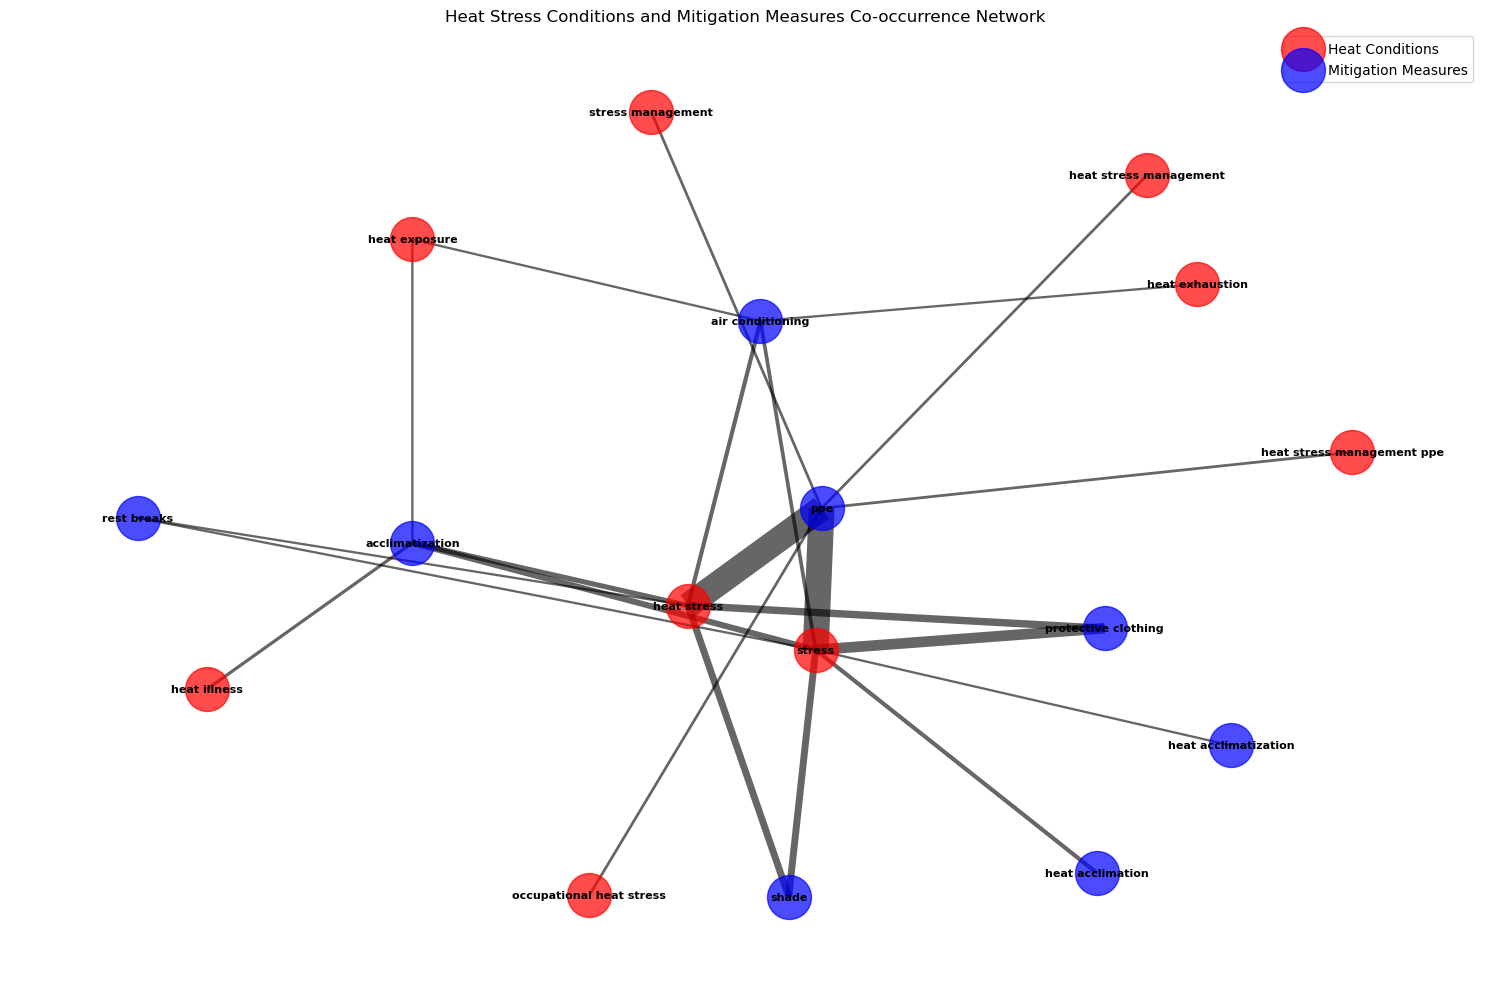

HEAT STRESS MITIGATION ANALYSIS RESULTS

ENTITY CATEGORIZATION:
Heat Conditions (1887):
  - heat stress: 129 mentions
  - heat exposure: 74 mentions
  - stress: 71 mentions
  - heat waves: 64 mentions
  - occupational heat stress: 58 mentions
  - high temperatures: 54 mentions
  - heat illness: 54 mentions
  - heat stroke: 53 mentions
  - thermal comfort: 52 mentions
  - the heat stress: 38 mentions

Mitigation Measures (119):
  - acclimatization: 79 mentions
  - air conditioning: 63 mentions
  - shade: 62 mentions
  - ventilation: 57 mentions
  - protective clothing: 48 mentions
  - fans: 38 mentions
  - rest breaks: 28 mentions
  - ppe: 21 mentions
  - heat acclimation: 18 mentions
  - heat acclimatization: 13 mentions

CONDITION-MITIGATION RECOMMENDATIONS:
(Based on co-occurrence analysis)

For 'stress':
  1. ppe
     Co-occurrence: 56, Frequency: 1, Score: 173.10
  2. protective clothing
     Co-occurrence: 23, Frequency: 1, Score: 89.51
  3. shade
     Co-occurrence: 15, Frequency

<Figure size 640x480 with 0 Axes>

In [69]:
# Main analysis function
def analyze_heat_stress_mitigations(entities_list, texts=None):
    """Main function to analyze heat stress mitigations"""
    print("Starting heat stress mitigation analysis...")
    
    # 1. Categorize entities
    print("\n1. Categorizing entities...")
    categories = categorize_entities(entities_list)
    print(f"Found {len(categories['conditions'])} heat conditions")
    print(f"Found {len(categories['mitigations'])} mitigation measures")
    print(f"Found {len(categories['other'])} other entities")
    
    # 2. Calculate frequency weights
    print("\n2. Calculating frequency weights...")
    frequency_weights = calculate_frequency_weights(entities_list)
    
    # 3. Calculate co-occurrence (if texts available)
    if texts is not None:
        print("\n3. Calculating co-occurrence matrix...")
        cooccurrence_matrix, unique_entities = calculate_cooccurrence_matrix(texts, entities_list)
        
        # 4. Find condition-mitigation pairs
        print("\n4. Finding condition-mitigation pairs...")
        condition_mitigation_pairs = find_condition_mitigation_pairs(
            cooccurrence_matrix, unique_entities, min_cooccurrence=2
        )
        
        # 5. Create recommendations
        print("\n5. Creating mitigation recommendations...")
        recommendations = create_mitigation_recommendations(
            condition_mitigation_pairs, frequency_weights
        )

        # Visualize the co-occurrence network
        G = visualize_cooccurrence_network(condition_mitigation_pairs, min_cooccurrence=5)
        
        return {
            'categories': categories,
            'frequency_weights': frequency_weights,
            'cooccurrence_matrix': cooccurrence_matrix,
            'unique_entities': unique_entities,
            'condition_mitigation_pairs': condition_mitigation_pairs,
            'recommendations': recommendations
        }
    else:
        # Simple frequency-based analysis without co-occurrence
        print("\n3. Creating frequency-based recommendations...")
        
        # Create simple recommendations based on frequency
        simple_recommendations = {}
        for condition in categories['conditions']:
            condition_freq = frequency_weights.get(condition, {}).get('count', 0)
            if condition_freq > 5:  # Only for frequently mentioned conditions
                mitigation_scores = []
                for mitigation in categories['mitigations']:
                    mit_data = frequency_weights.get(mitigation, {})
                    if mit_data.get('count', 0) > 3:
                        mitigation_scores.append({
                            'mitigation': mitigation,
                            'frequency': mit_data['count'],
                            'weight': mit_data['weight']
                        })
                
                mitigation_scores.sort(key=lambda x: x['weight'], reverse=True)
                simple_recommendations[condition] = mitigation_scores[:10]
        
        return {
            'categories': categories,
            'frequency_weights': frequency_weights,
            'simple_recommendations': simple_recommendations
        }


# Display results function
def display_mitigation_analysis(analysis_results):
    """Display the analysis results in a readable format"""
    
    print("="*80)
    print("HEAT STRESS MITIGATION ANALYSIS RESULTS")
    print("="*80)
    
    categories = analysis_results['categories']
    frequency_weights = analysis_results['frequency_weights']
    
    # Show categorization
    print(f"\nENTITY CATEGORIZATION:")
    print(f"Heat Conditions ({len(categories['conditions'])}):")
    for condition in sorted(categories['conditions'], 
                           key=lambda x: frequency_weights.get(x, {}).get('count', 0), 
                           reverse=True)[:10]:
        count = frequency_weights.get(condition, {}).get('count', 0)
        print(f"  - {condition}: {count} mentions")
    
    print(f"\nMitigation Measures ({len(categories['mitigations'])}):")
    for mitigation in sorted(categories['mitigations'], 
                           key=lambda x: frequency_weights.get(x, {}).get('count', 0), 
                           reverse=True)[:10]:
        count = frequency_weights.get(mitigation, {}).get('count', 0)
        print(f"  - {mitigation}: {count} mentions")
    
    # Show recommendations
    if 'recommendations' in analysis_results:
        recommendations = analysis_results['recommendations']
        print(f"\nCONDITION-MITIGATION RECOMMENDATIONS:")
        print(f"(Based on co-occurrence analysis)")
        
        for condition, mitigations in list(recommendations.items())[:5]:  # Top 5 conditions
            print(f"\nFor '{condition}':")
            for i, rec in enumerate(mitigations[:5], 1):  # Top 5 recommendations
                print(f"  {i}. {rec['mitigation']}")
                print(f"     Co-occurrence: {rec['cooccurrence']}, "
                      f"Frequency: {rec['mitigation_frequency']}, "
                      f"Score: {rec['composite_score']:.2f}")
    
    elif 'simple_recommendations' in analysis_results:
        recommendations = analysis_results['simple_recommendations']
        print(f"\nFREQUENCY-BASED RECOMMENDATIONS:")
        
        for condition, mitigations in list(recommendations.items())[:5]:
            print(f"\nFor '{condition}':")
            for i, rec in enumerate(mitigations[:5], 1):
                print(f"  {i}. {rec['mitigation']} (frequency: {rec['frequency']})")

# Run the analysis
print("Running heat stress mitigation analysis...")
analysis_results = analyze_heat_stress_mitigations(entities_all_papers_improved, all_cleaned_pdfs)

# Display results
display_mitigation_analysis(analysis_results)

<h2> Interpretation of the final analysis results: </h2>
1. A total of 1887 mentions were catogorized as heat conditions, and there were 119 mentions of mitigation measures.<br>
2. The analysis shows that the most frequently recommended mitigation strategies for heat conditions (especially heat stress and stress) are PPE, protective clothing, shade, acclimatization, air conditioning and rest breaks. It is worth noting that despite being widely recognized as an important mitigation measure in the other literature we reviewed manually + the interviews, 'hydration' is not part of the top entities, which may be due to some sort of shortcoming in the keywords or relevant terms I have selected; or because 138 papers are not sufficient. Nevertheless, the mitigation measures obtained through this analysis can be a good starting point for our website.<br>
3. The network graph shows the relationship between heat stress conditions (in red) and mitigation measures (in blue). There are two highly interconnected red nodes in the middle (heat stress, stress), suggesting that these are the two heat conditions that require the most mitigation strategies. Some heat conditions like heat exposure and heat illness are at the periphery. Some of the blue nodes (mitigation measures like protective clothing) address multiple heat conditions.

In [71]:
# Save analysis results
def save_analysis_to_text(analysis_results, filename="analysis_results.txt"):
    with open(filename, "w", encoding="utf-8") as f:
        f.write("="*80 + "\n")
        f.write("HEAT STRESS MITIGATION ANALYSIS RESULTS\n")
        f.write("="*80 + "\n\n")
        
        categories = analysis_results.get('categories', {})
        frequency_weights = analysis_results.get('frequency_weights', {})
        
        # Entity Categorization
        f.write("ENTITY CATEGORIZATION:\n")
        f.write(f"Heat Conditions ({len(categories.get('conditions', []))}):\n")
        for condition in sorted(categories.get('conditions', []), 
                                key=lambda x: frequency_weights.get(x, {}).get('count', 0), 
                                reverse=True):
            count = frequency_weights.get(condition, {}).get('count', 0)
            f.write(f"  - {condition}: {count} mentions\n")
        
        f.write(f"\nMitigation Measures ({len(categories.get('mitigations', []))}):\n")
        for mitigation in sorted(categories.get('mitigations', []), 
                                 key=lambda x: frequency_weights.get(x, {}).get('count', 0), 
                                 reverse=True):
            count = frequency_weights.get(mitigation, {}).get('count', 0)
            f.write(f"  - {mitigation}: {count} mentions\n")

        # Recommendations
        if 'recommendations' in analysis_results:
            f.write("\n\nCONDITION-MITIGATION RECOMMENDATIONS (Based on Co-occurrence):\n")
            recommendations = analysis_results['recommendations']
            for condition, mitigations in recommendations.items():
                f.write(f"\nFor '{condition}':\n")
                for i, rec in enumerate(mitigations, 1):
                    f.write(f"  {i}. {rec['mitigation']}\n")
                    f.write(f"     Co-occurrence: {rec['cooccurrence']}, "
                            f"Frequency: {rec['mitigation_frequency']}, "
                            f"Composite Score: {rec['composite_score']:.2f}\n")
        elif 'simple_recommendations' in analysis_results:
            f.write("\n\nSIMPLE RECOMMENDATIONS (Based on Frequency Only):\n")
            simple_recommendations = analysis_results['simple_recommendations']
            for condition, mitigations in simple_recommendations.items():
                f.write(f"\nFor '{condition}':\n")
                for i, rec in enumerate(mitigations, 1):
                    f.write(f"  {i}. {rec['mitigation']}\n")
                    f.write(f"     Frequency: {rec['frequency']}, Weight: {rec['weight']:.2f}\n")

        f.write("\n\nAnalysis saved successfully.\n")

save_analysis_to_text(analysis_results)
